In [53]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout, 
                                   BatchNormalization, Input, GlobalAveragePooling2D, 
                                   Concatenate, ReLU, AveragePooling2D)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
import numpy as np
import os
import cv2
import random
import albumentations as A
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns

# Introduce randomness
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  

# === Configuration ===
config = {
    "epochs": 1,
    "is_config_batch_size_param": True, # True means use the below batch_size parameter‌ / else let the function calculate the batch size
    "batch_size": 5,
    "initial_lr": 0.001,
    "gpu_memory_limit": 5,  # in GB
    "target_size": (480, 640),  # 2:3 ratio (width, height)
    "input_shape": (640, 480, 3), # (height, width, channels) for Keras
    "data_path": "Dataset/train_images/",
    "csv_path": "processed_data/cleaned_metadata_short.csv", # _short is for testing only
    "train_set_csv": "Model/training6_densenet_rgb/training6_densenet_rgb_train_set.csv",
    "val_set_csv": "Model/training6_densenet_rgb/training6_densenet_rgb_validation_set.csv",
    "history_csv": "Model/training6_densenet_rgb/training6_densenet_rgb_history.csv",
    "best_model": "Model/training6_densenet_rgb/training6_densenet_rgb_best_model.keras",
    "label_encoder_path": "Model/training6_densenet_rgb/training6_densenet_rgb_label_encoder.npy",
    "color_channel": "",
    "augmentation": [
            # A.RandomRotate90(),
            # A.HorizontalFlip(),
            # A.VerticalFlip(),
            # A.Transpose(),
            # A.RandomBrightnessContrast(p=0.5),
            # A.HueSaturationValue(p=0.5),
            A.CLAHE(p=0.5),
            A.Resize(width=480, height=640),
        ]
}



In [54]:
# === GPU Setup ===
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        policy = mixed_precision.Policy('float32')
        mixed_precision.set_global_policy(policy)
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        tf.config.threading.set_intra_op_parallelism_threads(8)
        tf.config.threading.set_inter_op_parallelism_threads(4)
    except RuntimeError as e:
        print(e)

# === Memory Management ===
def calculate_max_batch_size(model, input_shape, gpu_mem=24, default_batch=32, is_use_config_batch_size_param=config["is_config_batch_size_param"]):
    """Improved batch size calculator with error handling"""
    if is_use_config_batch_size_param:
        return default_batch
    try:
        params = model.count_params()
        
        last_dense = None
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Dense):
                last_dense = layer
                if layer.name == 'features':  
                    break
        
        if last_dense is None:
            raise ValueError("No Dense layer found in model!")
        
        # Memory per sample = weights + activations (in GB)
        per_sample = (
            (params * 4) +                 
            (np.prod(input_shape) * last_dense.units * 4)  
        ) / (1024 ** 3)
        
        # Max batch size with 3GB safety margin
        max_batch = int((gpu_mem - 3) / per_sample)
        return min(256, max_batch)  
    
    except Exception as e:
        print(f"Warning: Batch size estimation failed, using default={default_batch}. Error: {e}")
        return default_batch

def cleanup_gpu_memory():
    """Force clear GPU memory"""
    K.clear_session()
    tf.compat.v1.reset_default_graph()
    if tf.config.list_physical_devices('GPU'):
        try:
            for gpu in tf.config.list_physical_devices('GPU'):
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError:
            pass

# === Data Pipeline ===
def load_and_preprocess_data(random_state=42, save_splits=True):
    """Load and split data with fixed random state for reproducibility"""
    df = pd.read_csv(config["csv_path"])
    
    le = LabelEncoder()
    df['label_encoded'] = le.fit_transform(df['label'])
    print(f"Label classes: {le.classes_}")
    
    with open(config['label_encoder_path'], 'wb') as f:
        np.save(f, le.classes_)
    
    train_df, val_df = train_test_split(
        df, 
        test_size=0.2, 
        stratify=df['label'],
        random_state=random_state,
    )
    
    if save_splits:
        train_df.to_csv(config['train_set_csv'], index=False)
        val_df.to_csv(config['val_set_csv'], index=False)
    
    return train_df, val_df, le


In [55]:
# === Model Architecture ===
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(growth_rate, (3,3), padding='same')(y)
        x = Concatenate()([x, y])
    return x

def transition_layer(x, compression=0.5):
    filters = int(x.shape[-1] * compression)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (1,1), padding='same')(x)
    x = AveragePooling2D((2,2), strides=2)(x)
    return x

def create_densenet(input_shape, num_classes):
    inputs = Input(shape=input_shape, dtype=tf.float32)
    
    # Initial conv
    x = Conv2D(64, (7,7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    
    # Dense blocks (DenseNet-121 uses [6,12,24,16] layers)
    x = dense_block(x, 6, growth_rate=32)
    x = transition_layer(x)
    
    x = dense_block(x, 12, growth_rate=32)
    x = transition_layer(x)
    
    x = dense_block(x, 24, growth_rate=32)
    x = transition_layer(x)
    
    x = dense_block(x, 16, growth_rate=32)
    
    # Head
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

class RiceDataGenerator(Sequence):
    def __init__(self, df, base_path, batch_size=32, target_size={config['target_size']}, shuffle=False, debug=False, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.base_path = base_path
        self.batch_size = batch_size
        self.target_size = target_size  
        self.shuffle = shuffle
        self.debug = debug
        self.indices = np.arange(len(df))
        
        self.aug = A.Compose(config["augmentation"])
        
        if shuffle:
            np.random.shuffle(self.indices)
            
        if self.debug:
            self.visualize_samples()    
            

    def visualize_samples(self):        
        try:
            row = self.df.iloc[0]
            img = self._load_image(row['image_id'], row['label'])
            augmented = self.aug(image=img)
            
            plt.figure(figsize=(12, 6))
            
            # original
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Original\nShape: {img.shape}")
            
            # augmented
            plt.subplot(1, 2, 2)
            plt.imshow(augmented['image'])
            plt.title(f"Augmented\nShape: {augmented['image'].shape}")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Visualization failed for {row['image_id']}: {str(e)}")
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def _load_image(self, image_id, label, suffix=config["color_channel"]):
        img_path = os.path.join(
            self.base_path,
            label,
            f"{os.path.splitext(image_id)[0]}{suffix}.jpg"
        )
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
        return img
    
    def __getitem__(self, idx):
        batch_indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        
        X = np.zeros((len(batch_df), self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
        y = np.zeros((len(batch_df),), dtype=np.int32)
        
        for i, (_, row) in enumerate(batch_df.iterrows()):
            try:
                img = self._load_image(row['image_id'], row['label'])
                augmented = self.aug(image=img)
                X[i] = augmented['image'] / 255.0
                y[i] = row['label_encoded']
            except Exception as e:
                print(f"Error loading {row['image_id']}: {str(e)}")
                X[i] = np.zeros((self.target_size[1], self.target_size[0], 3), dtype=np.float32) #(batch, height, width, channels)
                y[i] = -1
                
        valid = y != -1
        return X[valid], y[valid]

# === Training ===
def train():
    cleanup_gpu_memory()
    
    try:
        train_df, val_df, le = load_and_preprocess_data(random_state=42)
        num_classes = len(le.classes_)
        print("Classes: ", num_classes)
        
        # Create the mopdel
        input_shape = config["input_shape"] 
        model = create_densenet(input_shape, num_classes)
        
        # Find optimal batch size
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        print(f"\n=== Training Configuration ===")
        print(f"Batch size: {optimized_batch_size}")
        print(f"Input size: {config['target_size']}")
        print(f"Classes: {num_classes}")
        print(f"GPU Memory: {config['gpu_memory_limit']}GB\n")
        print(f"Model input shape: {model.input_shape}")
        
        # Create generators for training and validation
        train_gen = RiceDataGenerator(
            df=train_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=True
        )
        
        val_gen = RiceDataGenerator(
            df=val_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,
            target_size=config["target_size"],
            shuffle=False,
            debug=False
        )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        sample_batch = train_gen[0]
        print(f"Generator output shape: {sample_batch[0].shape}")
        print(f"Model input shape: {model.input_shape}")
        
        # Train
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=config["epochs"],
            callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                    monitor='val_accuracy',
                    patience=5,  # Stop if no improvement in 5 epochs
                    mode='max',
                    restore_best_weights=True  
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    config["best_model"],  
                    save_weights_only=False,
                    monitor='val_accuracy',
                    save_best_only=True # Save the best model
                ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy',
                    factor=0.5,  # Halve Learn Rate if no improvement
                    patience=3,
                    mode='max'
                )
            ]
        )
        
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
        plt.axhline(y=max(history.history['val_accuracy']), color='r', linestyle='--', label='Best Val Accuracy')
        plt.legend()
        
        return model, history
        
    except Exception as e:
        print(f"Training failed: {e}")
        cleanup_gpu_memory()
        raise

In [56]:
def evaluate_saved_model(model_path, use_val_set=True):
    """Deterministic evaluation with debug checks"""
    try:
        # Load model 
        with open(config['label_encoder_path'], 'rb') as f:
            classes = np.load(f, allow_pickle=True)
        le = LabelEncoder()
        le.classes_ = classes

        model = tf.keras.models.load_model(model_path, compile=False) 
            
        cleanup_gpu_memory()
        optimized_batch_size = calculate_max_batch_size(
                                    model, 
                                    input_shape=config["input_shape"],
                                    gpu_mem=config["gpu_memory_limit"],
                                    default_batch=config["batch_size"],
                                )
        
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top3_acc')
            ]
        )

        eval_df = pd.read_csv(config["val_set_csv"]) if use_val_set else load_and_preprocess_data(save_splits=False)[1]
        print(f"Evaluating on {len(eval_df)} samples")

        eval_gen = RiceDataGenerator(
            df=eval_df,
            base_path=config["data_path"],
            batch_size=optimized_batch_size,  
            target_size=config["target_size"],
            shuffle=False,  
            debug=False,
        )

        # Inspect first batch
        x_test, y_test = eval_gen[0]
        print(f"\n[DEBUG] First batch - X shape: {x_test.shape}, y shape: {y_test.shape}")
        print(f"[DEBUG] Sample label: {y_test[0]} -> {le.classes_[y_test[0]]}")

        # Standard evaluation
        results = model.evaluate(eval_gen, verbose=1, return_dict=True)
        print("\n[METRICS] Evaluation Results:", results)

        # Collect all predictions
        y_true, y_pred = [], []
        for i in range(len(eval_gen)):
            x, y = eval_gen[i]
            y_true.extend(y)
            y_pred.extend(model.predict(x, verbose=0).argmax(axis=1))  # Get class indices

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        assert len(y_true) == len(y_pred), "Label/prediction length mismatch!"

        # Print sample predictions
        print("\n[PREDICTION SAMPLES]")
        for i in range(min(5, len(y_true))):
            print(f"True: {le.classes_[y_true[i]]} ({y_true[i]}) | Pred: {le.classes_[y_pred[i]]} ({y_pred[i]})")

        # Confusion Matrix Analysis
        print("\n[CONFUSION MATRIX PARAMETERS]")
        print(f"- Classes: {le.classes_}")  # Class names from LabelEncoder
        print(f"- Total samples: {len(y_true)}")
        print(f"- Batch size: {optimized_batch_size} (affects matrix granularity)")
        print(f"- Most confused classes: Will be visible in plot")

        # Plot both normalized and raw counts
        plot_confusion_matrix(
            y_true, 
            y_pred, 
            classes=le.classes_,
            normalize=True,
            title='Normalized Confusion Matrix (%)'
        )

        plot_confusion_matrix(
            y_true,
            y_pred,
            classes=le.classes_,
            normalize=False,
            title='Confusion Matrix (Counts)'
        )

        # Additional metrics
        from sklearn.metrics import classification_report
        print("\n[CLASSIFICATION REPORT]")
        print(classification_report(y_true, y_pred, target_names=le.classes_))

        return results

    except Exception as e:
        print(f"Evaluation failed: {e}")
        raise
    
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None):
    """
    Plots the confusion matrix.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        classes: List of class names
        normalize: Whether to normalize the matrix
        title: Plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, xticklabels=classes, yticklabels=classes,
                cmap='Blues', cbar=False)
    
    plt.title(title or 'Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


Label classes: ['bacterial_leaf_blight' 'bacterial_leaf_streak' 'blast' 'normal' 'tungro']
Classes:  5

=== Training Configuration ===
Batch size: 5
Input size: (480, 640)
Classes: 5
GPU Memory: 5GB

Model input shape: (None, 640, 480, 3)


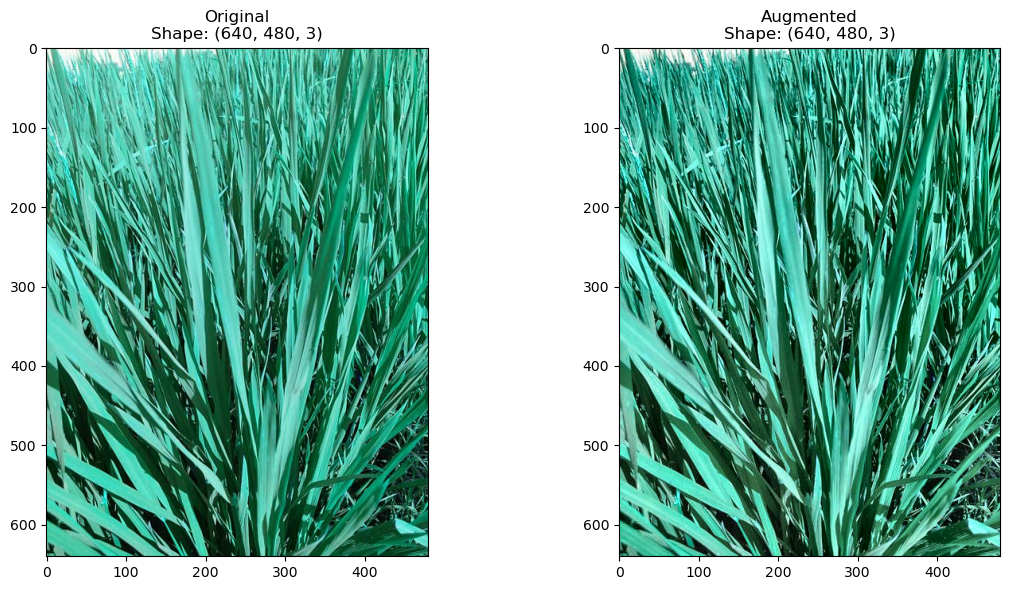

Generator output shape: (5, 640, 480, 3)
Model input shape: (None, 640, 480, 3)
9/9 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.1551 - loss: 13.0994 - val_accuracy: 0.2727 - val_loss: 354244.7500 - learning_rate: 0.0010
Evaluating on 11 samples

[DEBUG] First batch - X shape: (5, 640, 480, 3), y shape: (5,)
[DEBUG] Sample label: 2 -> blast
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 544ms/step - acc: 0.3114 - loss: 328707.7188 - top3_acc: 1.0000

[METRICS] Evaluation Results: {'acc': 0.27272728085517883, 'loss': 353819.71875, 'top3_acc': 1.0}

[PREDICTION SAMPLES]
True: blast (2) | Pred: blast (2)
True: bacterial_leaf_blight (0) | Pred: blast (2)
True: tungro (4) | Pred: blast (2)
True: blast (2) | Pred: blast (2)
True: bacterial_leaf_streak (1) | Pred: blast (2)

[CONFUSION MATRIX PARAMETERS]
- Classes: ['bacterial_leaf_blight' 'bacterial_leaf_streak' 'blast' 'normal' 'tungro']
- Total samples: 11
- Batch size: 5 (affects matrix granularity)
- Most confused classes: Will be visible in plot


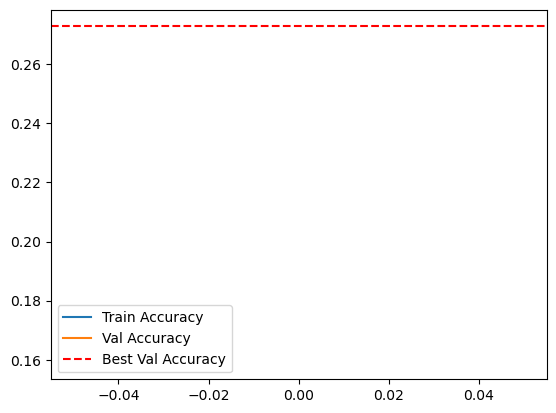

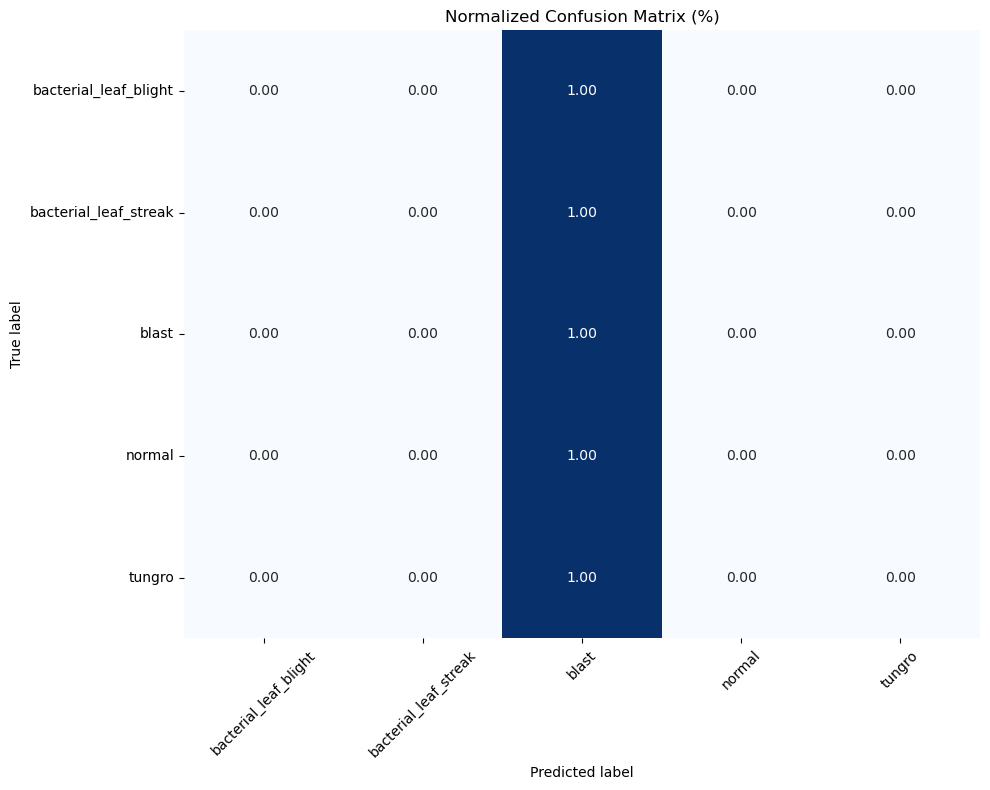

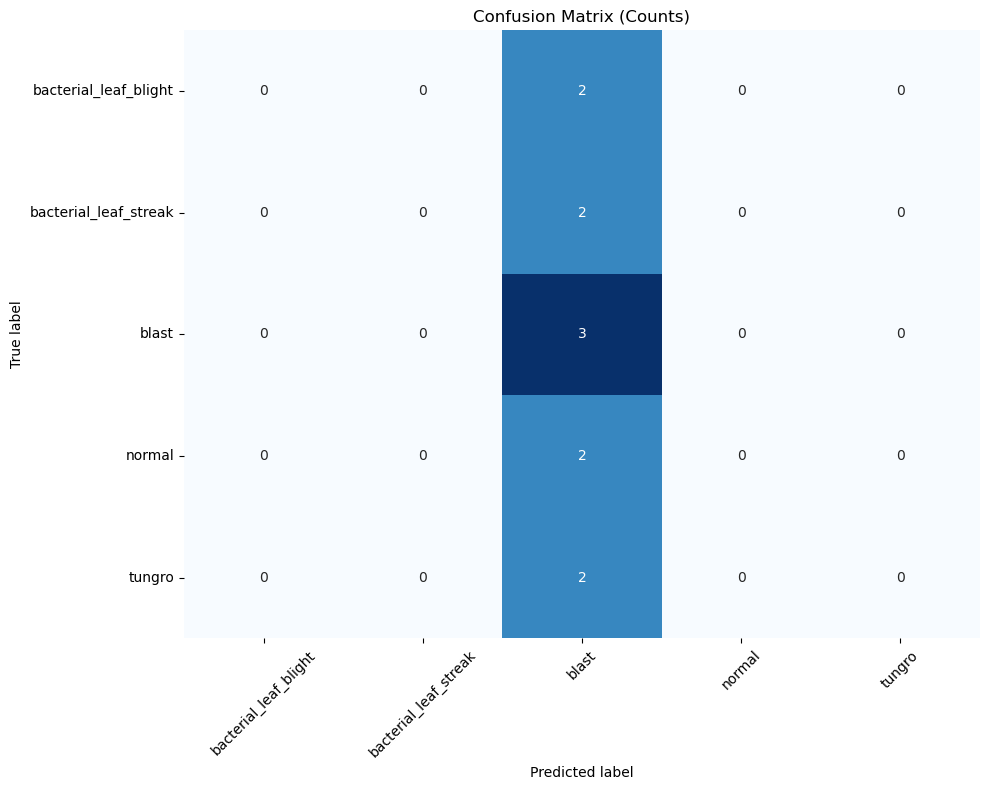


[CLASSIFICATION REPORT]
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.00      0.00      0.00         2
bacterial_leaf_streak       0.00      0.00      0.00         2
                blast       0.27      1.00      0.43         3
               normal       0.00      0.00      0.00         2
               tungro       0.00      0.00      0.00         2

             accuracy                           0.27        11
            macro avg       0.05      0.20      0.09        11
         weighted avg       0.07      0.27      0.12        11



/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/derrickle/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'acc': 0.27272728085517883, 'loss': 353819.71875, 'top3_acc': 1.0}

In [57]:
# === Execution Options ===
model, model_history = train()
# model.save(config["best_model"])
evaluate_saved_model(config["best_model"], use_val_set=True)